# Abalone

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from a pandas dataframe by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

## Create Datasets

In [3]:
# Reading a file from online
# more information can be found here:
# > https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/
h = ["sex",
"length",
"diameter",
"height",
"whole_weight",
"shucked_weight",
"viscera_weight",
"shell_weight",
"rings"]
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',names=h)

In [4]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "abalone",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "memory", "type": "pandas"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "iterate": {
            "return_type": "tuple",
            "schema": {
                "x": {
                    "length": {
                        "indicator": "length",
                        "datatype": {
                            "in": {"options": {"dtype": "float64", "shape": 1}},
                            "out": {},
                        },
                        "special": "decode",
                    },
                    "diameter": {
                        "indicator": "diameter",
                        "datatype": {
                            "in": {"options": {"dtype": "float64", "shape": 1}},
                            "out": {},
                        },
                        "special": "decode",
                    },
                },
                "y": {
                    "rings": {
                        "datatype": {
                            "in": {"options": {"dtype": "int64", "shape": 1}},
                            "out": {},
                        }
                    }
                },
            },
        },
    },
}

In [5]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict = dd.read(dd_dict, df)

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## Specify the Model

In [6]:
# %load_ext autoreload
# %autoreload 2
# import yeahml as yml

In [7]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

In [8]:
# import pprint
# pprint.pprint(yml_dict['hyper_parameters'])
# pprint.pprint(yml_dict['optimize'])
# pprint.pprint(yml_dict['performance'])

## Build the model

In [9]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
W0322 15:52:52.954067 139982176470848 base_layer.py:1790] Layer flatten_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

build_logger: INFO     information json file created


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_a (InputLayer)          [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           feature_a[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           48          flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            136         dense_1[0][0]                    
______________________________________________________________________________________________

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [11]:
# import pprint
# pprint.pprint(yml_dict['optimize'])
# print("--")
# pprint.pprint(yml_dict['performance'])

In [12]:
train_dict = yml.train_model(model, yml_dict, (ds_dict["train"], ds_dict["val"]))

train_logger: INFO     -> START training graph


In [13]:
print(train_dict)

{'loss': {'main_obj': {'train': {'mean': {'epoch': {'best': 10.915673, 'steps': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'values': [98.86153, 63.144627, 23.404459, 11.672293, 11.311729, 11.283953, 11.260312, 11.236186, 11.212077, 11.189831, 11.167494, 11.145869, 11.126118, 11.106438, 11.088249, 11.070588, 11.054109, 11.038118, 11.023775, 11.010006, 10.997562, 10.985516, 10.974818, 10.964202, 10.954963, 10.94552, 10.93713, 10.929206, 10.921472, 10.915673]}}}, 'val': {'mean': {'epoch': {'best': 10.531285, 'steps': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'values': [93.15002, 53.72584, 18.21077, 11.053293, 10.880101, 10.852899, 10.828446, 10.805059, 10.78275, 10.761921, 10.7420225, 10.723212, 10.705558, 10.688909, 10.67334, 10.658593, 10.644756, 10.631747, 10.61966, 10.608288, 10.59775, 10.587933, 10.578856, 10.570427, 10.562568, 10.555262, 10.54850

In [14]:
import matplotlib.pyplot as plt

In [16]:
# plt.plot(train_dict['joint']["main_obj__second_obj__joint_train"]["train"]["mean"]["epoch"]["values"])
# plt.plot(train_dict['joint']["main_obj__second_obj__joint_train"]["val"]["mean"]["epoch"]["values"])

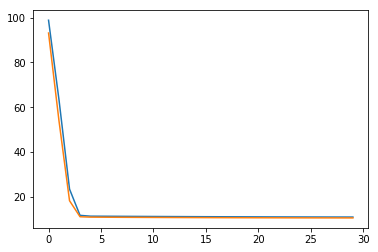

In [17]:
plt.plot(train_dict["loss"]["main_obj"]['train']["mean"]["epoch"]["values"])
plt.plot(train_dict["loss"]["main_obj"]['val']["mean"]["epoch"]["values"])

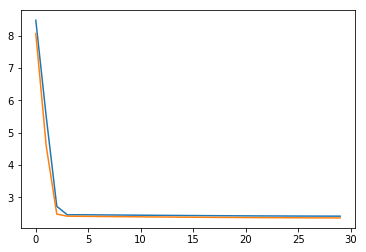

In [18]:
plt.plot(train_dict["loss"]["second_obj"]['train']["mean"]["epoch"]["values"])
plt.plot(train_dict["loss"]["second_obj"]['val']["mean"]["epoch"]["values"])

## Evaluate the Model

In [18]:
eval_dict = yml.eval_model(
    model,
    yml_dict,
    dataset=ds_dict["test"]
)
print(eval_dict)

ValueError: specified path is neither an h5 path, nor a directory containing directories of h5: yeahml/abalone/trial_00/model/run_2020_03_15-14_02_15/save/params/best_params.h5

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```